In [1]:
import torch   #Building the nerual network
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms  # to import the dataset directly into the notebook
from torch.utils.data import DataLoader   # to batch and shuffle data
import matplotlib.pyplot as plt  # to visvalise the data
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report  # for metric analysis

# ***Data transform:***

It is common to define the Transform pipeline as it converts the PIL format to numpy and tensor format

1.   **transforms.ToTensor()** --> Converts an PIL to numpy to Tensor
Scales the pixcel value from 0 - 255 to an normalized 0 - 1
2.   **transforms.Normalize((0.1307,),(0.3081,))** --> Standardises the dataset by subracting the mean(0.1307) and diving be the standard deviation (0.3081)

Here why do we take those Mean and Stand deviation?
Thats because instead of working with large pixel values we just convert it so that it fits between -1 to 1 and also the standard deviation is used to say how far it is from the mean value

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))  #Standard for MNIST
])

In [3]:
#--Load dataset--#

#We have set transform=transform in order to get the tensor ie convert th e image into tensor
#Download = True will make the dataset automatically download for the first time
train_dataset = datasets.MNIST(root='/.data', train=True, transform=transform, download=True)  # loads the 60000 train images
test_dataset = datasets.MNIST(root='/.data', train=False, transform=transform, download=True)   #loads the 10000 test images

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.06MB/s]


In [4]:
#Here batch means the model will see 1 batch at a time until it updates the weights...ie 64 images at once
#Also shuffle, shuffles the order after every epoch reducing the overfitting

train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)

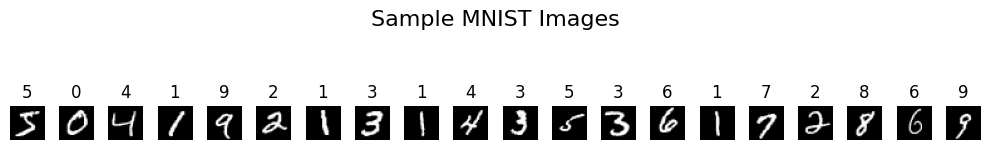

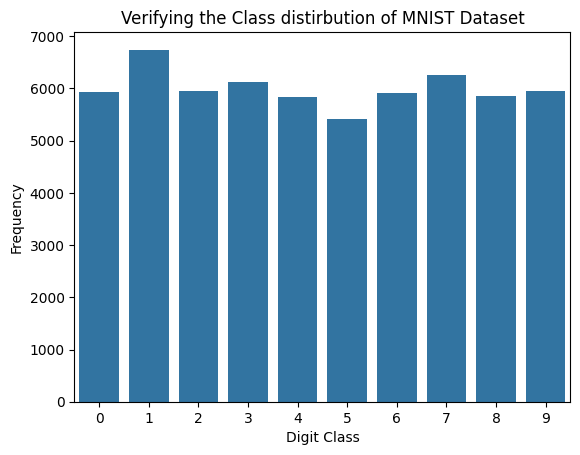

In [5]:
'''Here we are using EDA ie we are using Plot to see what kind of
data we are working on '''

#Looking the type of data we are working on
def show_samples(dataset,n=20):
  plt.figure(figsize=(10,2))
  for i in range(n):
    image,label = dataset[i]
    plt.subplot(1,n,i+1)
    plt.imshow(image.squeeze(),cmap='gray')
    plt.title(label)
    plt.axis('off')
  plt.suptitle("Sample MNIST Images", fontsize=16)
  plt.tight_layout()
  plt.show()
show_samples(train_dataset)

print()

#Checking the frequency of each classes
labels=[label for _, label in train_dataset]
sns.countplot(x=labels)
plt.title("Verifying the Class distirbution of MNIST Dataset")
plt.xlabel("Digit Class")
plt.ylabel("Frequency")
plt.show()

Until now we have only loaded the data set and used EDA that is to visvalise the type of data we are working on...now lets build the actual model using pytorch

In [6]:
#CNN creation!
class Model(torch.nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.conv1 = torch.nn.Conv2d(1,16,3, padding=1)# 1ip channel,16 filters, filter size 3x3...padding is added to make the output size remain the same
    self.pool = torch.nn.MaxPool2d(2,2) #it reduces the spacial features ie here it halves the height and width in the input
    self.conv2 = torch.nn.Conv2d(16,32,3, padding =1) #16 op from past, 32 new features
    self.fc1 = torch.nn.Linear(32*7*7,128)
    self.fc2 = torch.nn.Linear(128,10) #final output layer with 10 neurals

  def forward(self,x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1,32*7*7)
    x = torch.relu(self.fc1(x))
    return self.fc2(x)
model = Model()

In [7]:
#Main part is loss and optimizer
criterion = torch.nn.CrossEntropyLoss()  #crossEntropy is an go to choice for an multi class classification
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [9]:
#training loop:
epochs = 5
train_loss = []
for epoch in range(epochs):
  model.train()  #train mode
  running_loss = 0.0
  for images,labels in train_loader:
    optimizer.zero_grad()  #to reset the gradients from each step
    outputs = model(images)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()  #updates model weights
    running_loss +=loss.item()
  avg_loss = running_loss/len(train_loader)
  train_loss.append(avg_loss)
  print(f"Epoch [{epoch+1}/{epochs}], Loss:{avg_loss:.4f}")


Epoch [1/5], Loss:0.0531
Epoch [2/5], Loss:0.0368
Epoch [3/5], Loss:0.0269
Epoch [4/5], Loss:0.0215
Epoch [5/5], Loss:0.0170


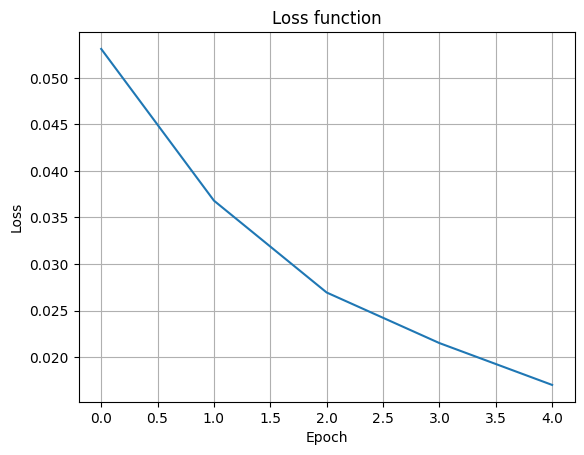

In [10]:
#lets plot the loss func out there
plt.plot(train_loss)
plt.title("Loss function")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [15]:
# now lets test how well our data will work by evaluating
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():  #to prevent pytorch from tracking gradient
  for images,labels in test_loader:
    output = model(images) # to check every image
    _, predicted = torch.max(output,1)  #exteact the highest classes with image
    all_preds.extend(predicted.numpy())
    all_labels.extend(labels.numpy())

#Accuracy and classification
print("\n Classification Report:")
print(classification_report(all_labels,all_preds))


 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



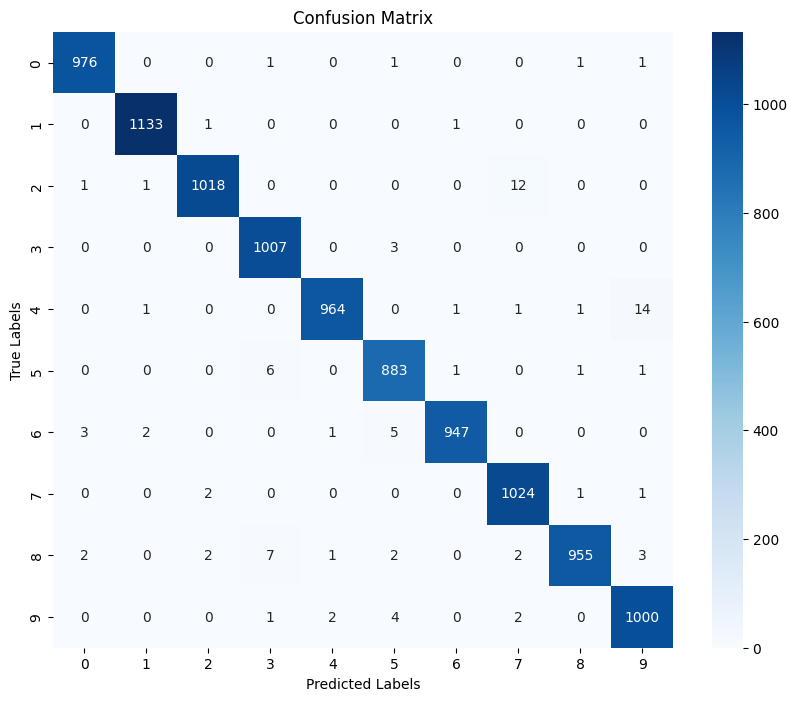

In [16]:
#Confusion matrix
conf_matrix = confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=range(10),yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Here the diagonal must be high value => it is high accuracy

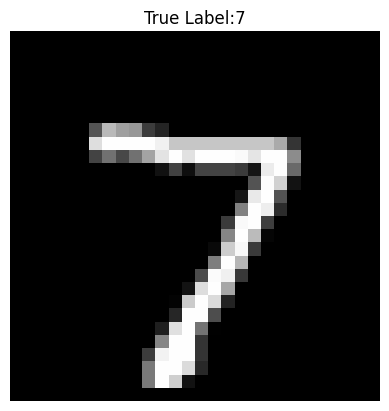

Predicted Class:7


In [22]:
#Lets check it out we an real time example fro mthe dataset

sample_img , sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(),cmap='gray')
plt.title(f"True Label:{sample_label}")
plt.axis('off')
plt.show()

sample_tensor = sample_img.unsqueeze(0)  # to remove from the batch
with torch.no_grad():
  output = model(sample_tensor)
  predicted_class = torch.argmax(output).item()
  print(f"Predicted Class:{predicted_class}")

All done!